In [1]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import torch
from torch import nn
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset
from torchvision import models, datasets
import torchvision.transforms as transforms
from tqdm.notebook import trange, tqdm
import matplotlib.pyplot as plt
from scipy.io import loadmat
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, random_split
import torchvision.models as models

# Hyperparameters
N_EPOCHS = 30
LEARNING_RATE = 0.0001
TEST_SIZE=0.20
BATCH_SIZE=128

# Transformations for our dataset
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 128x128
    transforms.ToTensor(),          # Convert PIL image to PyTorch tensor
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize to range [-1, 1] for better training stability
])

# Load the dataset
root_dir = 'data_projekt2_rgb/'  # Modify this to the path where your image folders (cat, chicken, etc.) are located
full_dataset = datasets.ImageFolder(root=root_dir, transform=transform)

# Splitting the dataset
train_size = int((1 - TEST_SIZE) * len(full_dataset))
test_size = len(full_dataset) - train_size

train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])

# Dataloaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [2]:
def get_resnet18_model(num_classes=4):
    resnet18 = models.resnet18(pretrained=True)
    
    # Freeze all layers in the network
    for param in resnet18.parameters():
        param.requires_grad = False

    # Replace the last fully connected layer
    num_features = resnet18.fc.in_features
    resnet18.fc = nn.Linear(num_features, num_classes)
    
    return resnet18


step = 16/4
step = 26/4
step = 62/4
step = 158/4

In [3]:
# define the loss functions and optimizers
# get_mobilenet_model()
# Load the model checkpoint
#checkpoint = torch.load('modely_zadanie_2/VGG16_model_2.pth')
model = get_resnet18_model()
#model.load_state_dict(checkpoint)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)   

/home/adambucko/workspace/hns/zadanie1_pismenka/.zadanie1_pismenka_venv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/adambucko/workspace/hns/zadanie1_pismenka/.zadanie1_pismenka_venv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [4]:
def evaluate_model(model, dataloader):
    """
    Evaluate the given model using the specified dataloader.

    Args:
    - model: Trained PyTorch model
    - dataloader: DataLoader for the evaluation data

    Returns:
    - Accuracy of the model on the evaluation data
    """
    correct = 0
    total = 0
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()  # Set model to evaluation mode

    with torch.no_grad():  # No need to track gradients during evaluation
        for inputs, labels in tqdm(dataloader, desc="Evaluation", leave=False):
            inputs, labels = inputs.to(device).float(), labels.to(device)  # Move inputs and labels to the device and ensure float32 type
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    return accuracy

In [5]:
# Training
def train_model(model, optimizer, criterion, dataloader_test,dataloader_train, epochs, unfreez, save_name):
    """
    Train a given model using the specified optimizer and criterion.

    Args:
    - model: PyTorch model to be trained
    - optimizer: Optimizer for updating model parameters
    - criterion: Loss function
    - dataloader: DataLoader for the training data
    - epochs: Number of epochs (default=10)

    Returns:
    - list of losses per epoch
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.train()  # Set the model to training mode
    loss_list_train, accuracy_list_train = [], []
    loss_list_test, accuracy_list_test = [], []
    freeze_first_n_layers = 0
    
    # Loop over epochs
    for epoch in trange(epochs, desc="Epochs"):
        # ... [rest of the code remains unchanged]
        epoch_loss_test = 0  # Initialize epoch loss
        epoch_loss_train=0
        model.zero_grad()
        count = 0

        if epoch < 3:
            freeze_first_n_layers = freeze_first_n_layers - step
        elif epoch < 6:
            freeze_first_n_layers = freeze_first_n_layers - 2*step
        elif epoch < 9:
            freeze_first_n_layers = freeze_first_n_layers - 3*step
        elif epoch < 12:
           freeze_first_n_layers = freeze_first_n_layers - 4*step

        if unfreez:
            # unfreeze backbone layers
            for param in model.children():
                count +=1
                if count > freeze_first_n_layers: 
                    param.requires_grad = True     

        for inputs, labels in tqdm(dataloader_train, desc="Training Batches", leave=False):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_loss_train += loss.item()

        # Calculate and store training accuracy and loss
        avg_loss_train = epoch_loss_train / len(dataloader_train)
        loss_list_train.append(avg_loss_train)
        accuracy_train = evaluate_model(model, dataloader_train)
        accuracy_list_train.append(accuracy_train)

        # Evaluate model on test data
        model.eval()
        epoch_loss_test = 0
        with torch.no_grad():
            for inputs, labels in tqdm(dataloader_test, desc="Test Batches", leave=False):
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                epoch_loss_test += loss.item()


        # Calculate and store test accuracy and loss
        avg_loss_test = epoch_loss_test / len(dataloader_test)
        loss_list_test.append(avg_loss_test)
        accuracy_test = evaluate_model(model, dataloader_test)
        accuracy_list_test.append(accuracy_test)
        print(f"Epoch {epoch+1}, Training Loss: {avg_loss_train:.6f}, Training Accuracy: {accuracy_train:.2f}%, Test Loss: {avg_loss_test:.6f}, Test Accuracy: {accuracy_test:.2f}%")


    #torch.save(model.state_dict(), 'modely_zadanie_2/' + save_name + ".pth")   
    model.eval()
    return loss_list_test, accuracy_list_test, loss_list_train, accuracy_list_train

In [6]:
# Augmentation
# Define a custom dataset class for rotated images
import random
class RotatedImageDataset(Dataset):
    def __init__(self, original_dataset, rotate_prob=1):
        self.original_dataset = original_dataset
        self.rotate_prob = rotate_prob

    def __len__(self):
        return len(self.original_dataset)

    def __getitem__(self, idx):
        image, label = self.original_dataset[idx]

        # Randomly decide whether to rotate the image or not
        should_rotate = random.random() < self.rotate_prob

        if should_rotate:
            # Rotate the image by 90 degrees
            image = transforms.functional.rotate(image, 90)

        return image, label

# Transformations for our dataset
transform = transforms.Compose([
    transforms.Resize((224, 224)), 
    transforms.ToTensor(),          
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize to range [-1, 1] for better training stability
])

original_dataset = datasets.ImageFolder(root=root_dir, transform=transform)

augment_data_size = int((1 - 0.6) * len(original_dataset))
unused_size = len(original_dataset) - augment_data_size
augment_data, unused = random_split(original_dataset, [augment_data_size, unused_size])
rotated_dataset = RotatedImageDataset(augment_data, rotate_prob=1)

train_size = int((1 - TEST_SIZE) * len(original_dataset))
test_size = len(original_dataset) - train_size
train_dataset, test_dataset = random_split(original_dataset, [train_size, test_size])
train_dataset = torch.utils.data.ConcatDataset([train_dataset, rotated_dataset])

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [7]:
if torch.cuda.is_available():
    print("cuda")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

criterion = nn.CrossEntropyLoss()

# Training the CNN model
cnn_optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
model.to(device)
cnn_losses_test,cnn_accuracy_test,cnn_losses_train,cnn_accuracy_train = train_model(model, cnn_optimizer, criterion,test_loader,train_loader, epochs=N_EPOCHS, unfreez=True, save_name='resnet18_test')


cuda


Epochs:   0%|          | 0/30 [00:00<?, ?it/s]

Training Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/19 [00:00<?, ?it/s]

Test Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 1, Training Loss: 1.421974, Training Accuracy: 32.14%, Test Loss: 1.374331, Test Accuracy: 31.99%


Training Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/19 [00:00<?, ?it/s]

Test Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 2, Training Loss: 1.321914, Training Accuracy: 44.58%, Test Loss: 1.284622, Test Accuracy: 48.36%


Training Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/19 [00:00<?, ?it/s]

Test Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 3, Training Loss: 1.237899, Training Accuracy: 56.72%, Test Loss: 1.195562, Test Accuracy: 62.72%


Training Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/19 [00:00<?, ?it/s]

Test Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 4, Training Loss: 1.161768, Training Accuracy: 67.82%, Test Loss: 1.121732, Test Accuracy: 72.04%


Training Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/19 [00:00<?, ?it/s]

Test Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 5, Training Loss: 1.088588, Training Accuracy: 75.59%, Test Loss: 1.053412, Test Accuracy: 79.09%


Training Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/19 [00:00<?, ?it/s]

Test Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 6, Training Loss: 1.025584, Training Accuracy: 80.08%, Test Loss: 0.990566, Test Accuracy: 82.12%


Training Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/19 [00:00<?, ?it/s]

Test Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 7, Training Loss: 0.966446, Training Accuracy: 82.94%, Test Loss: 0.934382, Test Accuracy: 86.40%


Training Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/19 [00:00<?, ?it/s]

Test Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 8, Training Loss: 0.913374, Training Accuracy: 85.08%, Test Loss: 0.883372, Test Accuracy: 87.91%


Training Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/19 [00:00<?, ?it/s]

Test Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 9, Training Loss: 0.864226, Training Accuracy: 86.60%, Test Loss: 0.837071, Test Accuracy: 89.17%


Training Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/19 [00:00<?, ?it/s]

Test Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 10, Training Loss: 0.818778, Training Accuracy: 87.65%, Test Loss: 0.795374, Test Accuracy: 90.43%


Training Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/19 [00:00<?, ?it/s]

Test Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 11, Training Loss: 0.779938, Training Accuracy: 88.61%, Test Loss: 0.756301, Test Accuracy: 91.18%


Training Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/19 [00:00<?, ?it/s]

Test Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 12, Training Loss: 0.741445, Training Accuracy: 89.37%, Test Loss: 0.720875, Test Accuracy: 91.94%


Training Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/19 [00:00<?, ?it/s]

Test Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 13, Training Loss: 0.707007, Training Accuracy: 90.00%, Test Loss: 0.688914, Test Accuracy: 92.44%


Training Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/19 [00:00<?, ?it/s]

Test Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 14, Training Loss: 0.674740, Training Accuracy: 90.63%, Test Loss: 0.657852, Test Accuracy: 93.20%


Training Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/19 [00:00<?, ?it/s]

Test Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 15, Training Loss: 0.645440, Training Accuracy: 90.92%, Test Loss: 0.631495, Test Accuracy: 93.45%


Training Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/19 [00:00<?, ?it/s]

Test Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 16, Training Loss: 0.619254, Training Accuracy: 91.30%, Test Loss: 0.607107, Test Accuracy: 93.45%


Training Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/19 [00:00<?, ?it/s]

Test Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 17, Training Loss: 0.592644, Training Accuracy: 91.89%, Test Loss: 0.581922, Test Accuracy: 93.95%


Training Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/19 [00:00<?, ?it/s]

Test Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 18, Training Loss: 0.569431, Training Accuracy: 92.06%, Test Loss: 0.561298, Test Accuracy: 94.46%


Training Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/19 [00:00<?, ?it/s]

Test Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 19, Training Loss: 0.547273, Training Accuracy: 92.44%, Test Loss: 0.540531, Test Accuracy: 94.71%


Training Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/19 [00:00<?, ?it/s]

Test Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 20, Training Loss: 0.527441, Training Accuracy: 92.69%, Test Loss: 0.520455, Test Accuracy: 94.96%


Training Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/19 [00:00<?, ?it/s]

Test Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 21, Training Loss: 0.507605, Training Accuracy: 92.94%, Test Loss: 0.503972, Test Accuracy: 95.21%


Training Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/19 [00:00<?, ?it/s]

Test Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 22, Training Loss: 0.490856, Training Accuracy: 93.24%, Test Loss: 0.485659, Test Accuracy: 95.21%


Training Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/19 [00:00<?, ?it/s]

Test Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 23, Training Loss: 0.473470, Training Accuracy: 93.40%, Test Loss: 0.472266, Test Accuracy: 95.21%


Training Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/19 [00:00<?, ?it/s]

Test Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 24, Training Loss: 0.457590, Training Accuracy: 93.87%, Test Loss: 0.456130, Test Accuracy: 95.21%


Training Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/19 [00:00<?, ?it/s]

Test Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 25, Training Loss: 0.441318, Training Accuracy: 94.20%, Test Loss: 0.440175, Test Accuracy: 95.47%


Training Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/19 [00:00<?, ?it/s]

Test Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 26, Training Loss: 0.427776, Training Accuracy: 94.54%, Test Loss: 0.428408, Test Accuracy: 95.47%


Training Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/19 [00:00<?, ?it/s]

Test Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 27, Training Loss: 0.414182, Training Accuracy: 94.66%, Test Loss: 0.415472, Test Accuracy: 95.47%


Training Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/19 [00:00<?, ?it/s]

Test Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 28, Training Loss: 0.401776, Training Accuracy: 95.17%, Test Loss: 0.403696, Test Accuracy: 95.72%


Training Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/19 [00:00<?, ?it/s]

Test Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 29, Training Loss: 0.389567, Training Accuracy: 95.42%, Test Loss: 0.392151, Test Accuracy: 95.72%


Training Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/19 [00:00<?, ?it/s]

Test Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 30, Training Loss: 0.376866, Training Accuracy: 95.50%, Test Loss: 0.381118, Test Accuracy: 95.97%


In [8]:
import pickle

# # Save the lists to a file
# with open('cnn_losses1.pkl', 'wb') as f:
#     pickle.dump(cnn_losses1, f)

# with open('cnn_accuracy_list1.pkl', 'wb') as f:
#     pickle.dump(cnn_accuracy_list1, f)

# with open('cnn_losses1.pkl', 'rb') as f:
#     cnn_losses1 = pickle.load(f)

# with open('cnn_accuracy_list1.pkl', 'rb') as f:
#     cnn_accuracy_list1 = pickle.load(f)

In [9]:
import matplotlib.pyplot as plt

def plot_accuracy(accuracy_test,accuracy_train, model_name):

    plt.figure(figsize=(12, 6))
    plt.plot(accuracy_test, '-o', label=f'{model_name} Accuracy - Test')
    plt.plot(accuracy_train, '-o', label=f'{model_name} Accuracy - Train')
    plt.title(f'Accuracy Evolution for {model_name}')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.tight_layout()
    plt.show()



In [10]:
import matplotlib.pyplot as plt

def plot_losses(cnn_losses_test,cnn_losses_train, model_name):

    plt.figure(figsize=(12, 6))
    plt.plot(cnn_losses_test, '-o', label=f'{model_name} Losses  Test')
    plt.plot(cnn_losses_train, '-o', label=f'{model_name} Losses  Train')
    plt.title(f'Training Loss evolution for {model_name}')
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.show()



In [11]:

def plot_filters(layer):
    # Extract filter weights from the layer and convert to numpy for visualization.
    filters = layer.weight.data.cpu().numpy()
    
    # Calculate the number of rows and columns for the grid.
    num_filters = filters.shape[0]
    num_rows = num_columns = int(np.ceil(np.sqrt(num_filters)))
    
    # Initialize a figure for displaying the filter images.
    fig, axes = plt.subplots(num_rows, num_columns, figsize=(10, 10))
    
    # Loop through each filter in the layer and display it in the grid.
    for i in range(num_filters):
        row, col = i // num_columns, i % num_columns
        ax = axes[row, col]
        ax.imshow(filters[i][0], cmap='gray')
        ax.axis('off')
    
    # Remove any empty subplots in the grid.
    for i in range(num_filters, num_rows * num_columns):
        fig.delaxes(axes.flatten()[i])
    
    plt.show()



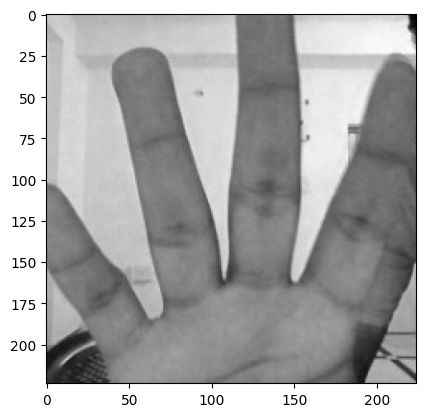

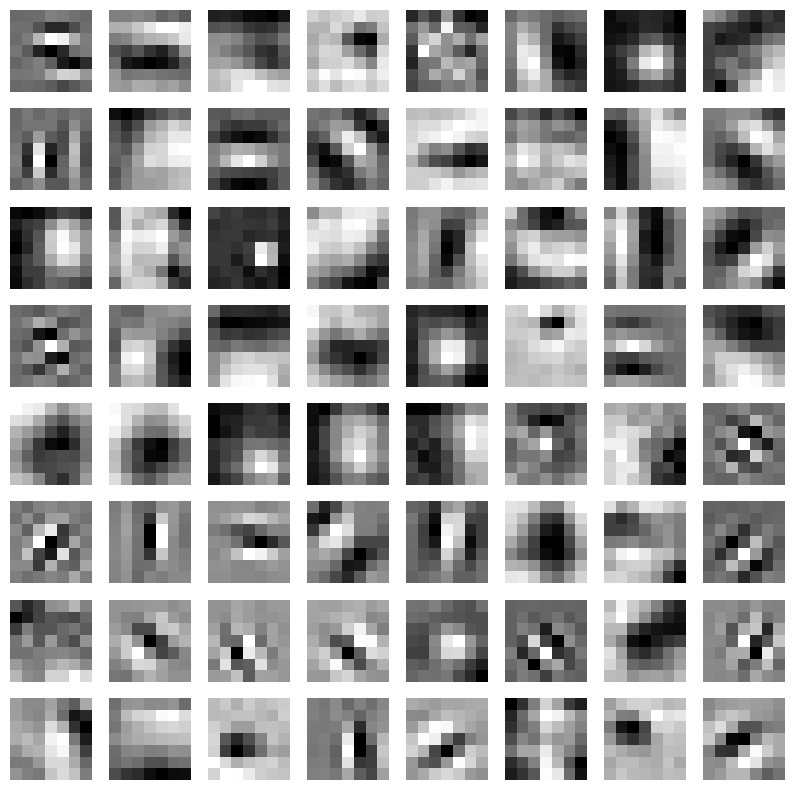

In [12]:
def visualize_feature_maps(model, input_image):
    # Making sure model is in eval mode
    model.eval()
    
    # Running the image through the first conv layer
    first_conv_layer = model.features[0]
    second_conv_layer = model.features[2] 

    feature_maps1 = first_conv_layer(input_image.unsqueeze(0).float().to(device))
    feature_maps2 = second_conv_layer(feature_maps1)
    # If you want to visualize after the second conv layer
    # feature_maps2 = model.conv2(F.relu(feature_maps1))
    
    n_feature_maps1 = feature_maps1.shape[1]
    n_feature_maps2 = feature_maps2.shape[1]
    
    # Plotting each feature map
    for i in range(n_feature_maps1):
        plt.subplot(8, 8, i+1)  # Assuming a max of 64 feature maps for display
        plt.imshow(feature_maps1[0][i].cpu().detach().numpy(), cmap='gray')
        plt.axis('off')
    plt.show()

    for i in range(n_feature_maps2):
        plt.subplot(8, 8, i+1)  # Assuming a max of 64 feature maps for display
        plt.imshow(feature_maps2[0][i].cpu().detach().numpy(), cmap='gray')
        plt.axis('off')
    plt.show()



# Select a random image from the dataset
image, _ = test_dataset[1]
plt.imshow(image[0], cmap='gray')  # Displaying the selected image
plt.show()

# Displaying feature maps for the selected image
# visualize_feature_maps(model, image)
plot_filters(model.conv1)

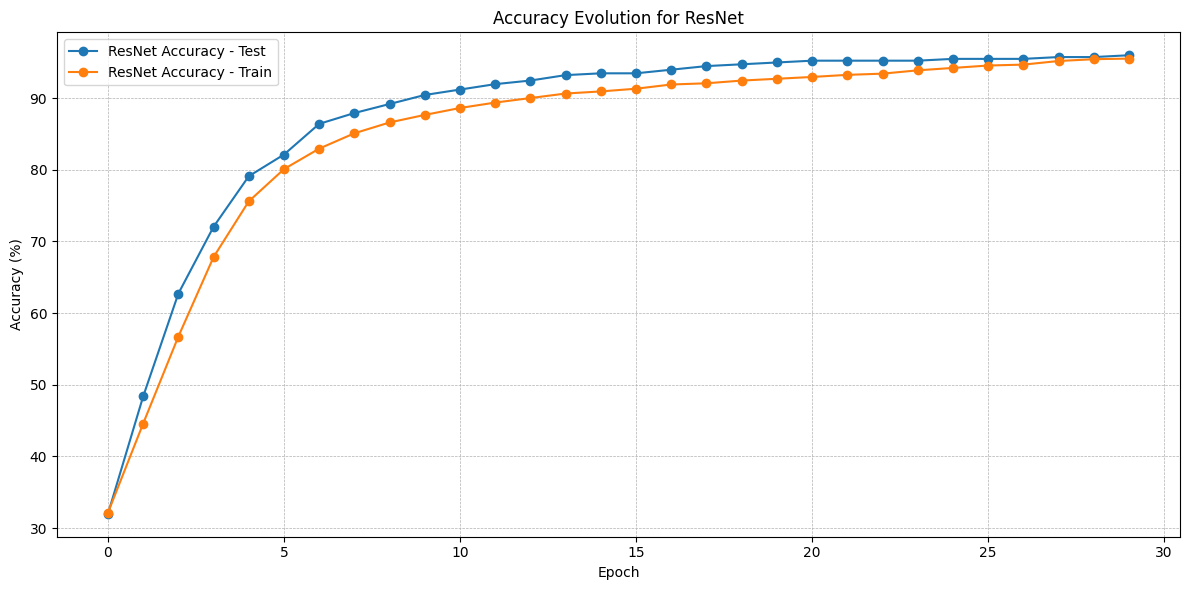

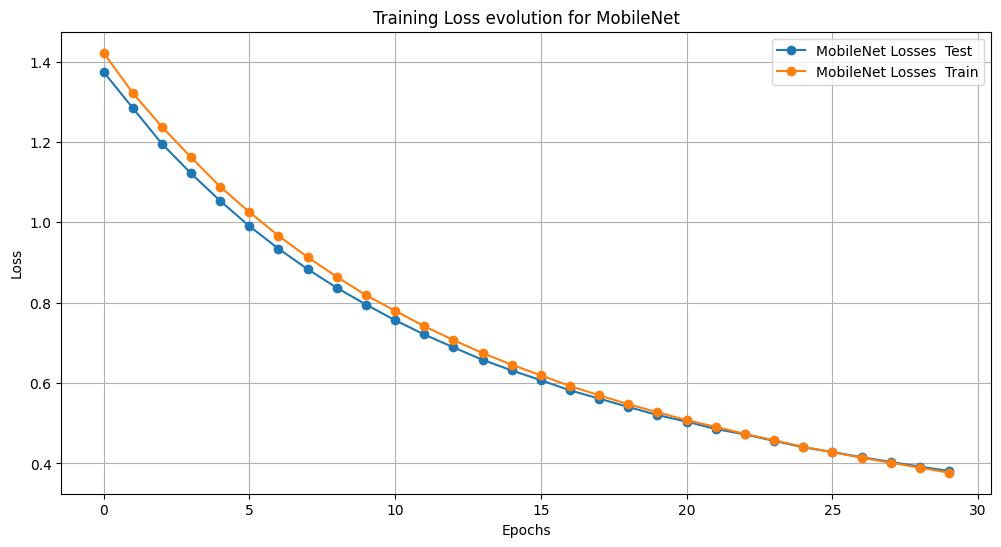

In [13]:
plot_accuracy(cnn_accuracy_test, cnn_accuracy_train, "ResNet")
plot_losses(cnn_losses_test, cnn_losses_train, "MobileNet")

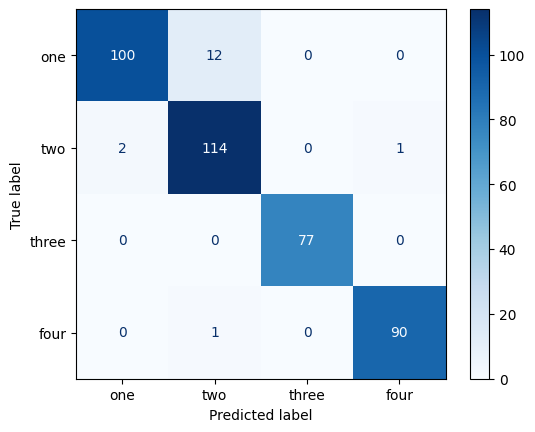

In [15]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Load the model checkpoint
#checkpoint = torch.load('modely_zadanie_2/VGG16_model_3.pth')
#model = get_vgg16_model()
#model.load_state_dict(checkpoint)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

def get_all_preds_and_labels(model, dataloader):
    # Empty tensors to store all predictions and true labels.
    all_preds = torch.tensor([]).to(device)
    all_labels = torch.tensor([]).to(device)
    
    # Loop through the data in the dataloader.
    for inputs, labels in dataloader:
        # Convert inputs to float32
        inputs = inputs.float()
        # Move the data to the device (GPU/CPU).
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Forward pass to get predictions.
        outputs = model(inputs)
        
        # Get the index (class label) with the maximum score as the prediction.
        _, preds = torch.max(outputs, 1)
        
        # Append the batch's predictions and labels to the accumulating tensors.
        all_preds = torch.cat((all_preds, preds), dim=0)
        all_labels = torch.cat((all_labels, labels), dim=0)
    
    # Return all predictions and true labels.
    return all_preds, all_labels

import numpy as np
from sklearn import metrics

def plot_confusion_matrix(all_preds, all_labels):
    # Compute the confusion matrix using sklearn's function.
    cm = metrics.confusion_matrix(all_labels.cpu(), all_preds.cpu())
    
    # Define the labels you're using (in this case, it's A-J).
    labels = ["one","two","three","four"]
    
    # Create the ConfusionMatrixDisplay object.
    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    
    # Plot the confusion matrix.
    cm_display.plot(cmap='Blues')
    plt.show()

# After training your CNN model
cnn_model = model.float()
all_preds, all_labels = get_all_preds_and_labels(cnn_model, test_loader)
plot_confusion_matrix(all_preds, all_labels)
